# IBM Capstone project for IBM Advanced Data Science | Alex Braga

Author: Alex Braga | alexbraga101@gmail.com

This notebook summarize the work done towards the conclusion on IBM Advanced Data Science on Coursera.
The purpose the is to build up a data science project for a real world use case by taking the steps taught during the specialization.

# Dataset
The first step for this problem was to select a dataset with a potential application in a field of interest of the candidate.

For this project a dataset available in one of Kaggle's competition was used.
https://www.kaggle.com/c/career-con-2019

Special thanks to Tampere University in Finland, Department of Signal Processing and Department of Automation and Mechanics Engineering for making the data available

Data was collected from a robot in 9 different surfaces taking IMU data(10 channels), each data series have 128 measurements and refer to a single surface category.

# Use Case
The objetive of the competition and this project is to predict the floor surface the robot is on based on collect IMU data.
This can be applied to real world cases that the surface impact the robot operation, for example vaccum cleaner robot could adapt their suction power and wheel encoder erros reading based on the surface its on, or even further could be applied to connected vehicles to rank a road condition when running on it, and the sharing this data with infrastructure management for road maintanance.

So now let's dive into the code!

First let's get all the dependencies

In [1]:
import numpy as np
import pandas as pd
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
get_ipython().magic(u'matplotlib inline')
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot, barplot
from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.style as style
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()
pd.set_option('display.max_columns', 100)
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
from sklearn.decomposition import PCA
from scipy.stats import kurtosis
from scipy.stats import skew
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow import keras
from numpy import array
from numpy import argmax
from numpy.fft import *
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import gc
from sklearn.model_selection import train_test_split
def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:])

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(abs(xn_i2-xn))

def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))

Using TensorFlow backend.


# Reading Data
Now we can load the Data into a pandas dataset, X is the raw measurement data from the sensors and Y is the surface label for each 128 step measurement

In [2]:
X_data = pd.read_csv('X_train.csv')
Y_data = pd.read_csv('y_train.csv')

# Data Exploration
In this step we will be able to anwser questions like What data is available? What type of data is available? how much data and is it distributed? 

At first, let's check their shape

In [3]:
X_data.shape

(487680, 13)

In [4]:
Y_data.shape

(3810, 3)

So we don't have the same amount of rows in X and Y data, that may be an issue. We had better that a view on these data.

In [5]:
X_data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
Y_data.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


X_data contains 10 channels measurements from the robots IMU data, each measurement series is separatable by the series_id row, and within each series we can check each measurement_number.
Y_data in the order hand assign the surface label for each series, that explains the difference in the number of rows among them.
And it also became evidence that further ahead we will need to transfed X_data in series_id group.

Now let's check the data type available

In [7]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [8]:
Y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 3 columns):
series_id    3810 non-null int64
group_id     3810 non-null int64
surface      3810 non-null object
dtypes: int64(2), object(1)
memory usage: 89.4+ KB


Nothing very special in the result, we only need to take consideration that the label is provided in string formating, we should probably change it to int or one hot encoding afterwards to simplify the training.

Let's plot basic statics on the data to start to check for any quality issues

In [9]:
X_data.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [10]:
Y_data.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


By using the helper function bellow we can get a series measurement plot.

Carpet


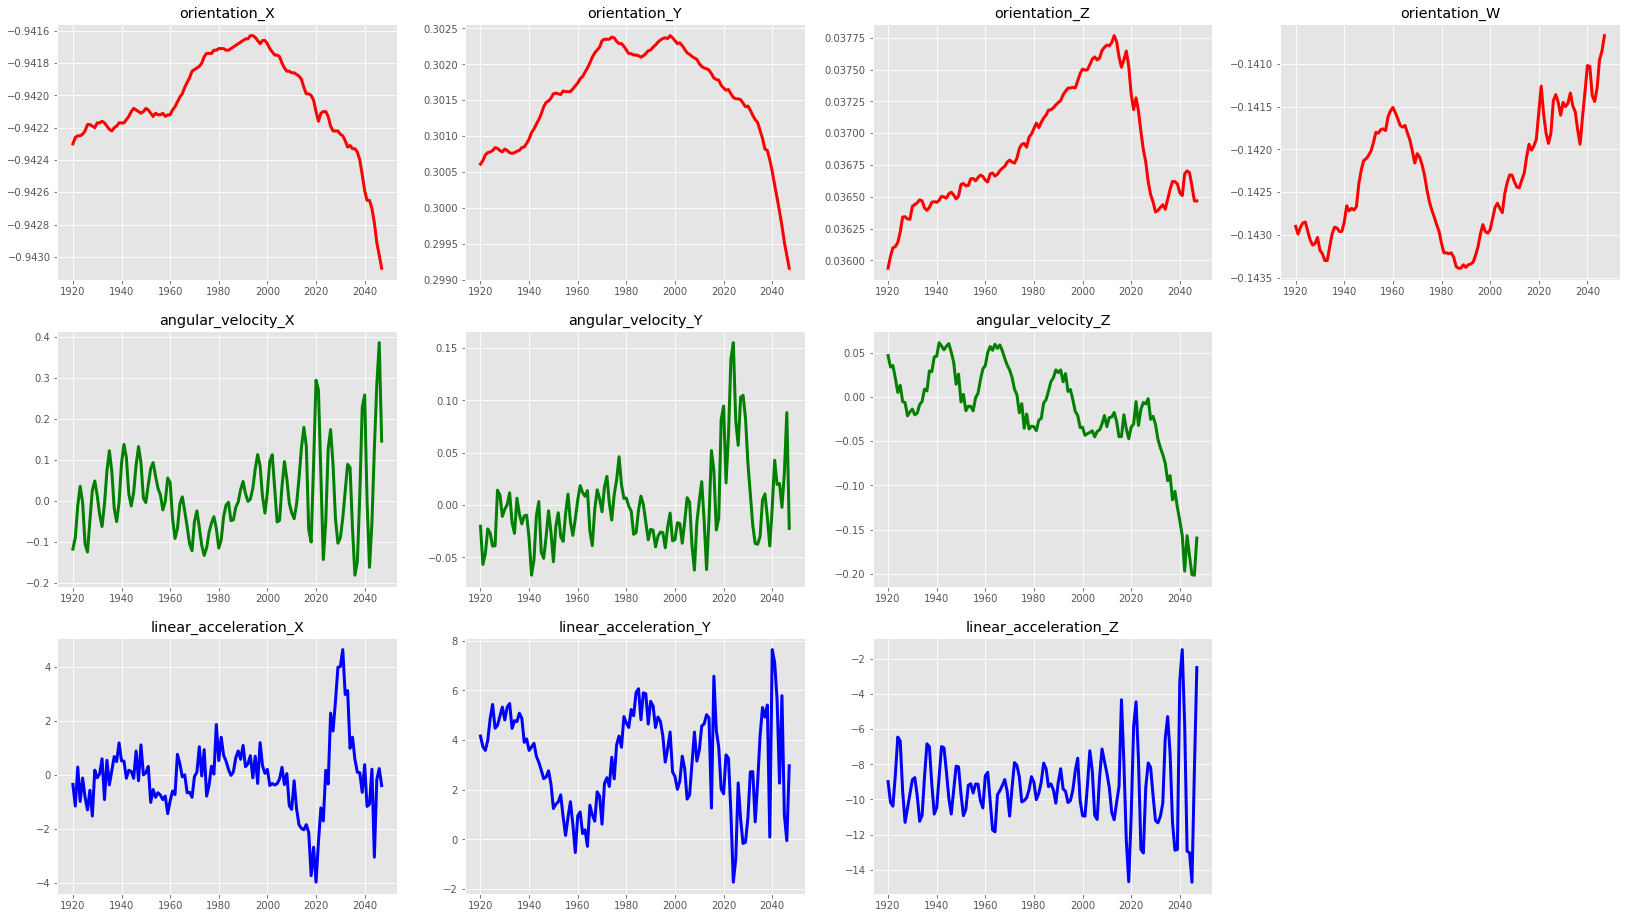

In [11]:
series_dict = {}
for series in (X_data['series_id'].unique()):
    series_dict[series] = X_data[X_data['series_id'] == series]

def plotSeries(series_id):
    style.use('ggplot')
    plt.figure(figsize=(28, 16))
    print(Y_data[Y_data['series_id'] == series_id]['surface'].values[0].title())
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        if col.startswith("o"):
            color = 'red'
        elif col.startswith("a"):
            color = 'green'
        else:
            color = 'blue'
        if i >= 7:
            i+=1
        plt.subplot(3, 4, i + 1)
        plt.plot(series_dict[series_id][col], color=color, linewidth=3)
        plt.title(col)

id_series = 15
plotSeries(id_series)

Some channels appear to have very noise data, that may be intrinsic to the sensor itslef and not the environment the robot it is running.
We should have better filter these input later on.

Let's see how the different types of surfaces are distributed in the given data

In [12]:
Y_data['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

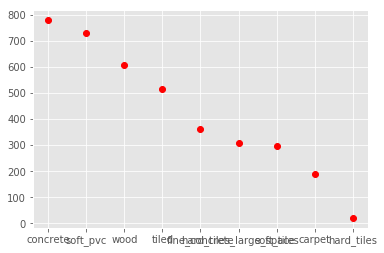

In [13]:
plt.plot(Y_data['surface'].value_counts(),'ro')

There are nine different floor surfaces, the dataset is not evenly distributed and hard_tiles have very few examples, which may cause a difficult on learning its pattern.

# Data Cleansing
Now that an overview of the data was provided, let's go ahead and cleanup any potential quality issues that may impact our model training

Check with there is any null or duplicate measurements and labels

In [14]:
X_data.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [15]:
Y_data.isnull().sum()

series_id    0
group_id     0
surface      0
dtype: int64

In [16]:
X_data.duplicated().value_counts()

False    487680
dtype: int64

In [17]:
X_data.shape

(487680, 13)

In [18]:
Y_data.duplicated().value_counts()

False    3810
dtype: int64

In [19]:
Y_data.shape

(3810, 3)

In [20]:
X_data.fillna(0, inplace = True)
X_data.replace(-np.inf, 0, inplace = True)
X_data.replace(np.inf, 0, inplace = True)
Y_data.fillna(0, inplace = True)
Y_data.replace(-np.inf, 0, inplace = True)
Y_data.replace(np.inf, 0, inplace = True)

No problem, looks like the data was already prechecked for the kaggle competition. Let's go create new features and transform the data for the model.

# Feature Engineering

In this step we will start to create new features for our model.
The first transformation is to add the equivalent rotation in euler angles given the raw data quaternion data.
In robotics the use of quaternion is widespread to avoid the gimbal lock issue that may occurs when using euler representation.
The gimbal lock issue refers to the lack of representativeness of the euler model when two axis allign during a rotation process.
So let's add euler angles to the data:

In [21]:
#https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
#quaternion to eular
def quaternion_to_euler(qx,qy,qz,qw):
    import math
    # roll (x-axis rotation)
    sinr_cosp = +2.0 * (qw * qx + qy + qz)
    cosr_cosp = +1.0 - 2.0 * (qx * qx + qy * qy)
    roll = math.atan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis rotation)
    sinp = +2.0 * (qw * qy - qz * qx)
    if(math.fabs(sinp) >= 1):
        pitch = copysign(M_PI/2, sinp)
    else:
        pitch = math.asin(sinp)

    # yaw (z-axis rotation)
    siny_cosp = +2.0 * (qw * qz + qx * qy)
    cosy_cosp = +1.0 - 2.0 * (qy * qy + qz * qz)
    yaw = math.atan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

def eular_angle(data):
    x, y, z, w = data['orientation_X'].tolist(), data['orientation_Y'].tolist(), data['orientation_Z'].tolist(), data['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)

    data['euler_x'] = nx
    data['euler_y'] = ny
    data['euler_z'] = nz

    return data

eular_angle(X_data).head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,-2.198206,-0.024668,1.396664
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,-2.198203,-0.024662,1.396646
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,-2.198178,-0.024728,1.396682
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,-2.198146,-0.024770,1.396721
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,-2.198135,-0.024784,1.396693


Now we will tackle the sensor noise. Since this noise don't bring usefull information for our model and may even affect its performance, we had better filter all data as described in the following steps.

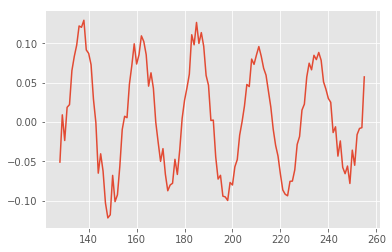

In [22]:
plt.plot(X_data.angular_velocity_Z[128:256])

In [23]:
def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

X_data_denoised = X_data.copy()

for col in X_data.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        # Apply filter_signal function to the data in each series
        denoised_data = X_data.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))

        # Assign the denoised data back to X_data
        list_denoised_data = []
        for arr in denoised_data:
            for val in arr:
                list_denoised_data.append(val)

        X_data_denoised[col] = list_denoised_data
        
series_dict = {}
for series in (X_data_denoised['series_id'].unique()):
    series_dict[series] = X_data_denoised[X_data_denoised['series_id'] == series]


In [24]:
X_data=X_data_denoised.copy()

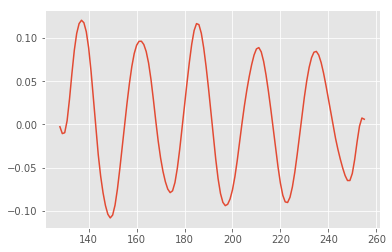

In [25]:
plt.plot(X_data_denoised.angular_velocity_Z[128:256])

As of now all data is separated in each axis, so we can create features calculating the magnitude a relation between them.

In [26]:
X_data['total_angular_vel'] = (X_data['angular_velocity_X']**2 + X_data['angular_velocity_Y']**2 + X_data['angular_velocity_Z']**2)** 0.5
X_data['total_linear_acc'] = (X_data['linear_acceleration_X']**2 + X_data['linear_acceleration_Y']**2 + X_data['linear_acceleration_Z']**2)**0.5
X_data['total_orientation'] = (X_data['orientation_X']**2 + X_data['orientation_Y']**2 + X_data['orientation_Z']**2)**0.5
X_data['acc_vs_vel'] = X_data['total_linear_acc'] / X_data['total_angular_vel']
X_data['total_angle'] = (X_data['euler_x'] ** 2 + X_data['euler_y'] ** 2 + X_data['euler_z'] ** 2) ** 0.5
X_data['angle_vs_acc'] = X_data['total_angle'] / X_data['total_linear_acc']
X_data['angle_vs_vel'] = X_data['total_angle'] / X_data['total_angular_vel']

Finally we can bring the data from the 128 time step to a measurement domain by using basic statics of the time series from each measurement.

In [27]:
Input = pd.DataFrame()
for col in X_data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        print ("FE on column ", col, "...")
        Input[col + '_mean'] = X_data.groupby(['series_id'])[col].mean()
        Input[col + '_median'] = X_data.groupby(['series_id'])[col].median()
        Input[col + '_max'] = X_data.groupby(['series_id'])[col].max()
        Input[col + '_min'] = X_data.groupby(['series_id'])[col].min()
        Input[col + '_std'] = X_data.groupby(['series_id'])[col].std()
        

FE on column  orientation_X ...
FE on column  orientation_Y ...
FE on column  orientation_Z ...
FE on column  orientation_W ...
FE on column  angular_velocity_X ...
FE on column  angular_velocity_Y ...
FE on column  angular_velocity_Z ...
FE on column  linear_acceleration_X ...
FE on column  linear_acceleration_Y ...
FE on column  linear_acceleration_Z ...
FE on column  euler_x ...
FE on column  euler_y ...
FE on column  euler_z ...
FE on column  total_angular_vel ...
FE on column  total_linear_acc ...
FE on column  total_orientation ...
FE on column  acc_vs_vel ...
FE on column  total_angle ...
FE on column  angle_vs_acc ...
FE on column  angle_vs_vel ...


With the measurement domain data in hand, we will normalize each column

In [28]:
x = Input.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Input = pd.DataFrame(x_scaled)

The target label data type is string so we should transform it to a unique int label.

In [29]:
le=LabelEncoder()
Y_data['surface'] = le.fit_transform(Y_data['surface'])
Y_data.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


Let's divide the data in test and train using 80/20 ratio given then small dataset.

In [30]:
xTrain, xTest, yTrain, yTest = train_test_split(Input, Y_data, test_size=0.2, random_state = 0)

One of the models in the next chapter will be a neural network. Then the label data is transform to a one hot encoded data

In [31]:
encoded = to_categorical(yTrain['surface'])
yTrainOHE = pd.DataFrame(encoded)

encoded = to_categorical(yTest['surface'])
yTestOHE = pd.DataFrame(encoded)

yTrainOHE.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Model | Neural Network

First model to be included is a neural network with a sequential topology using a sigmoid activation function and a one hot encoded output.

In [32]:
[xTrain.shape, xTest.shape, yTrainOHE.shape, yTestOHE.shape]

[(3048, 100), (762, 100), (3048, 9), (762, 9)]

In [33]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_shape=(100,), activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(32,activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(16,activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(9,activation=tf.nn.softmax))

model.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

model.fit(xTrain, yTrainOHE, epochs=50)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
3048/3048 [==============================] - 0s 66us/sample - loss: 2.1891 - categorical_accuracy: 0.1972
Epoch 2/50
3048/3048 [==============================] - 0s 32us/sample - loss: 2.0094 - categorical_accuracy: 0.2152
Epoch 3/50
3048/3048 [==============================] - 0s 32us/sample - loss: 1.7984 - categorical_accuracy: 0.3425
Epoch 4/50
3048/3048 [==============================] - 0s 32us/sample - loss: 1.5752 - categorical_accuracy: 0.4042
Epoch 5/50
3048/3048 [==============================] - 0s 33us/sample - loss: 1.4479 - categorical_accuracy: 0.4738
Epoch 6/50
3048/3048 [==============================] - 0s 32us/sample - loss: 1.3452 - categorical_accuracy: 0.5174
Epoch 7/50
3048/3048 [==============================] - 0s 32us/sample - loss: 1.2366 - categorical_accuracy: 0.5633
Epoch 8/50
3048/3048 [==============================] - 0s 32

In [34]:
model.evaluate(xTest,yTestOHE)

762/762 [==============================] - 0s 85us/sample - loss: 0.5579 - categorical_accuracy: 0.8163


[0.5578744890182976, 0.816273]

Even with a small model and few iterations of parameter tuning it was possible to achieve over 75% of accuracy.

# Model | Random Forest

Second model is the Random Forest, which creates a structure of decision trees to absorb the data patterns and represent the model. It is well now for the good performance on multiclassification problems.

In [35]:
yTrain.head()

,series_id,group_id,surface
3257,3257,70,5
3017,3017,62,1
3355,3355,38,8
1763,1763,72,2
1044,1044,33,4


In [36]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)
predicted = np.zeros((xTest.shape[0],9))
measured= np.zeros((Input.shape[0]))
score = 0

for times, (trn_idx, val_idx) in enumerate(folds.split(Input.values,Y_data['surface'].values)):
    model2 = RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_split=5, n_jobs=-1)
    model2.fit(Input.iloc[trn_idx],Y_data['surface'][trn_idx])
    measured[val_idx] = model2.predict(Input.iloc[val_idx])
    predicted += model2.predict_proba(xTest)/folds.n_splits
    score += model2.score(Input.iloc[val_idx],Y_data['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model2.score(Input.iloc[val_idx],Y_data['surface'][val_idx])))

    gc.collect()

Fold: 0 score: 0.7023498694516971
Fold: 1 score: 0.7633986928104575
Fold: 2 score: 0.6968503937007874
Fold: 3 score: 0.6934210526315789
Fold: 4 score: 0.7357992073976222


In [37]:
print('Average score', score / folds.n_splits)

Average score 0.7183638431984287


Work on tuning was more demanding than from the neural network and even so the perfomance is still lower than the previous model.

In [38]:
confusion_matrix(measured,Y_data['surface'])

array([[ 63,   4,   0,   0,   1,   1,   2,   0,   2],
       [ 30, 652,  29,   0,  32,  38,  10,  75,  52],
       [  5,   3, 178,   0,   4,   8,   7,   3,   5],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  23,   9,   0, 237,   8,   0,   5,   0],
       [ 35,  50,  49,  13,  10, 632,  37,  35, 123],
       [ 14,  12,  13,   1,   5,  20, 234,  10,  19],
       [  5,  17,  45,   0,   2,   7,   0, 383,  48],
       [ 35,  18,  40,   7,  17,  18,   7,   3, 358]])

Text(0.5, 24.0, 'Predicted label')

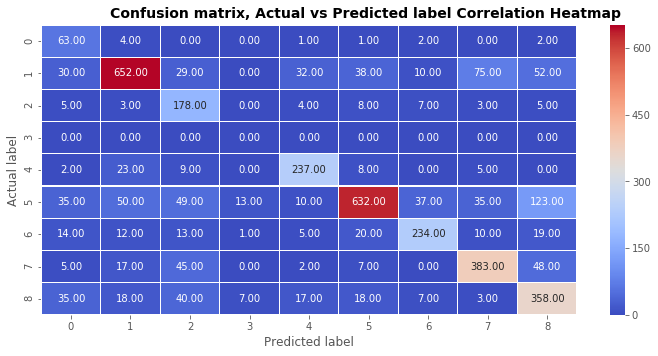

In [39]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.heatmap(pd.DataFrame(confusion_matrix(measured,Y_data['surface'])),
            ax = ax,
            cmap = 'coolwarm',
            annot = True,
            fmt = '.2f',
            linewidths = 0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Confusion matrix, Actual vs Predicted label Correlation Heatmap',
              fontsize=14,
              fontweight='bold')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Feature Engineering 2

One actions to improve the perfomance of the classifiers is improving the data in itself. So before making anymore tunings in the model, let's create additional features.

In [40]:
Input2=Input.copy()
for col in X_data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        print ("FE on column ", col, "...")
        #Input2[col + '_range'] = Input2[col + '_max'] - Input2[col + '_min']
        #Input2[col + '_maxtoMin'] = Input2[col + '_max'] / Input2[col + '_min']
        Input2[col + '_mad'] = X_data.groupby(['series_id'])[col].apply(lambda x: np.median(np.abs(np.diff(x))))
        Input2[col + '_abs_max'] = X_data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        Input2[col + '_abs_min'] = X_data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        Input2[col + '_abs_avg'] = (Input2[col + '_abs_min'] + Input2[col + '_abs_max'])/2
        Input2[col + '_skew'] = X_data.groupby(['series_id'])[col].skew()
        Input2[col + '_mad'] = X_data.groupby(['series_id'])[col].mad()
        Input2[col + '_q25'] = X_data.groupby(['series_id'])[col].quantile(0.25)
        Input2[col + '_q75'] = X_data.groupby(['series_id'])[col].quantile(0.75)
        Input2[col + '_q95'] = X_data.groupby(['series_id'])[col].quantile(0.95)
        Input2[col + '_iqr'] = Input2[col + '_q75'] - Input2[col + '_q25']
        Input2[col + '_SSC'] = X_data.groupby(['series_id'])[col].apply(SSC)
        Input2[col + '_skewness'] = X_data.groupby(['series_id'])[col].apply(skewness)
        Input2[col + '_wave_lenght'] = X_data.groupby(['series_id'])[col].apply(wave_length)
        Input2[col + '_norm_entropy'] = X_data.groupby(['series_id'])[col].apply(norm_entropy)
        Input2[col + '_SRAV'] = X_data.groupby(['series_id'])[col].apply(SRAV)
        Input2[col + '_kurtosis'] = X_data.groupby(['series_id'])[col].apply(_kurtosis)
        Input2[col + '_zero_crossing'] = X_data.groupby(['series_id'])[col].apply(zero_crossing)

FE on column  orientation_X ...
FE on column  orientation_Y ...
FE on column  orientation_Z ...
FE on column  orientation_W ...
FE on column  angular_velocity_X ...
FE on column  angular_velocity_Y ...
FE on column  angular_velocity_Z ...
FE on column  linear_acceleration_X ...
FE on column  linear_acceleration_Y ...
FE on column  linear_acceleration_Z ...
FE on column  euler_x ...
FE on column  euler_y ...
FE on column  euler_z ...
FE on column  total_angular_vel ...
FE on column  total_linear_acc ...
FE on column  total_orientation ...
FE on column  acc_vs_vel ...
FE on column  total_angle ...
FE on column  angle_vs_acc ...
FE on column  angle_vs_vel ...


We normalize the data again and encode the label

In [41]:

x2 = Input2.values
min_max_scaler2 = preprocessing.MinMaxScaler()
x_scaled2 = min_max_scaler2.fit_transform(x2)
Input2 = pd.DataFrame(x_scaled2)

In [42]:
Y_data2=Y_data.copy()
le2=LabelEncoder()
Y_data2['surface'] = le.fit_transform(Y_data['surface'])
Y_data2.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


Separated in test and train, additionally transform the label into a one hot encoded shape.

In [43]:
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(Input2, Y_data2, test_size=0.2, random_state = 0)

In [44]:
encoded2 = to_categorical(yTrain2['surface'])
yTrainOHE2 = pd.DataFrame(encoded2)

encoded2 = to_categorical(yTest2['surface'])
yTestOHE2 = pd.DataFrame(encoded2)

yTrainOHE2.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Model | Neural Network 2

We repeat the previous chapter steps and bring on improvements in to model to accomodate the new data.

In [45]:
[xTrain2.shape, xTest2.shape, yTrainOHE2.shape, yTestOHE2.shape]

[(3048, 420), (762, 420), (3048, 9), (762, 9)]

In [46]:
model3 = keras.Sequential()
model3.add(keras.layers.Dense(256, input_shape=(420,), activation=tf.nn.sigmoid))
model3.add(keras.layers.Dense(128,activation=tf.nn.sigmoid))
model3.add(keras.layers.Dense(64,activation=tf.nn.sigmoid))
model3.add(keras.layers.Dense(32,activation=tf.nn.sigmoid))
model3.add(keras.layers.Dense(9,activation=tf.nn.softmax))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model3.fit(xTrain2, yTrainOHE2, epochs=200)


Epoch 1/200
3048/3048 [==============================] - 1s 168us/sample - loss: 2.0715 - acc: 0.1972
Epoch 2/200
3048/3048 [==============================] - 0s 103us/sample - loss: 1.9926 - acc: 0.2470
Epoch 3/200
3048/3048 [==============================] - 0s 99us/sample - loss: 1.8090 - acc: 0.3671
Epoch 4/200
3048/3048 [==============================] - 0s 98us/sample - loss: 1.6699 - acc: 0.3996
Epoch 5/200
3048/3048 [==============================] - 0s 91us/sample - loss: 1.5884 - acc: 0.4236
Epoch 6/200
3048/3048 [==============================] - 0s 107us/sample - loss: 1.5349 - acc: 0.4616
Epoch 7/200
3048/3048 [==============================] - 0s 90us/sample - loss: 1.4551 - acc: 0.4964
Epoch 8/200
3048/3048 [==============================] - 0s 88us/sample - loss: 1.3980 - acc: 0.5249
Epoch 9/200
3048/3048 [==============================] - 0s 93us/sample - loss: 1.3289 - acc: 0.5614
Epoch 10/200
3048/3048 [==============================] - 0s 87us/sample - loss: 1.2746 

3048/3048 [==============================] - 0s 113us/sample - loss: 0.1465 - acc: 0.9508
Epoch 81/200
3048/3048 [==============================] - 0s 90us/sample - loss: 0.1350 - acc: 0.9603
Epoch 82/200
3048/3048 [==============================] - 0s 90us/sample - loss: 0.1284 - acc: 0.9613
Epoch 83/200
3048/3048 [==============================] - 0s 90us/sample - loss: 0.1234 - acc: 0.9629
Epoch 84/200
3048/3048 [==============================] - 0s 90us/sample - loss: 0.1290 - acc: 0.9613
Epoch 85/200
3048/3048 [==============================] - 0s 89us/sample - loss: 0.1267 - acc: 0.9596
Epoch 86/200
3048/3048 [==============================] - 0s 91us/sample - loss: 0.1352 - acc: 0.9577
Epoch 87/200
3048/3048 [==============================] - 0s 90us/sample - loss: 0.1180 - acc: 0.9626
Epoch 88/200
3048/3048 [==============================] - 0s 89us/sample - loss: 0.1129 - acc: 0.9656
Epoch 89/200
3048/3048 [==============================] - 0s 92us/sample - loss: 0.1176 - acc:

3048/3048 [==============================] - 0s 90us/sample - loss: 0.0101 - acc: 0.9980
Epoch 160/200
3048/3048 [==============================] - 0s 91us/sample - loss: 0.0094 - acc: 0.9987
Epoch 161/200
3048/3048 [==============================] - 0s 88us/sample - loss: 0.0208 - acc: 0.9954
Epoch 162/200
3048/3048 [==============================] - 0s 88us/sample - loss: 0.0203 - acc: 0.9938
Epoch 163/200
3048/3048 [==============================] - 0s 112us/sample - loss: 0.0187 - acc: 0.9951
Epoch 164/200
3048/3048 [==============================] - 1s 226us/sample - loss: 0.0592 - acc: 0.9803
Epoch 165/200
3048/3048 [==============================] - 0s 90us/sample - loss: 0.0613 - acc: 0.9783
Epoch 166/200
3048/3048 [==============================] - 0s 153us/sample - loss: 0.0338 - acc: 0.9902
Epoch 167/200
3048/3048 [==============================] - 1s 265us/sample - loss: 0.0247 - acc: 0.9925
Epoch 168/200
3048/3048 [==============================] - 0s 92us/sample - loss: 0

In [47]:
model3.evaluate(xTest2,yTestOHE2)

762/762 [==============================] - 0s 126us/sample - loss: 0.3634 - acc: 0.9094


[0.3634368342364554, 0.9094488]

With the tuned and topology changes it was achieved a 90.15% accuraccy.

# Model | Random Forest 2

Same as the previous, we adjust model shape and tune parameters to improve the performance.

In [48]:
folds2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=60)
predicted2 = np.zeros((xTest.shape[0],9))
measured2= np.zeros((Input.shape[0]))
score2 = 0

for times, (trn_idx, val_idx) in enumerate(folds2.split(Input2.values,Y_data2['surface'].values)):
    model4 = RandomForestClassifier(n_estimators=700, max_depth=20, min_samples_split=5, n_jobs=-1)
    model4.fit(Input2.iloc[trn_idx],Y_data2['surface'][trn_idx])
    measured2[val_idx] = model4.predict(Input2.iloc[val_idx])
    predicted2 += model4.predict_proba(xTest2)/folds2.n_splits
    score2 += model4.score(Input2.iloc[val_idx],Y_data2['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model4.score(Input2.iloc[val_idx],Y_data2['surface'][val_idx])))

    gc.collect()

Fold: 0 score: 0.9116883116883117
Fold: 1 score: 0.9114583333333334
Fold: 2 score: 0.9164490861618799
Fold: 3 score: 0.9240837696335078
Fold: 4 score: 0.889763779527559
Fold: 5 score: 0.8871391076115486
Fold: 6 score: 0.9081364829396326
Fold: 7 score: 0.9102902374670184
Fold: 8 score: 0.9259259259259259
Fold: 9 score: 0.9122340425531915


In [49]:
print('Average score', score2 / folds2.n_splits)

Average score 0.9097169076841908


The final accuracy with tuned parameters and additional data features the accuracy reached 90.60%

In [50]:
confusion_matrix(measured2,Y_data2['surface'])

array([[157,   5,   0,   0,   3,   1,   0,   2,   0],
       [ 13, 711,  12,   0,  17,  13,   5,  22,  15],
       [  0,   6, 322,   0,   3,   7,   1,   0,   5],
       [  0,   0,   0,  14,   0,   0,   0,   0,   0],
       [  0,   5,   1,   0, 277,   5,   0,   3,   1],
       [  3,  18,   5,   0,   1, 683,   4,   4,  18],
       [  2,   6,   0,   1,   0,   6, 281,   8,   0],
       [  1,  12,   4,   0,   0,   3,   0, 469,  16],
       [ 13,  16,  19,   6,   7,  14,   6,   6, 552]])

Text(0.5, 24.0, 'Predicted label')

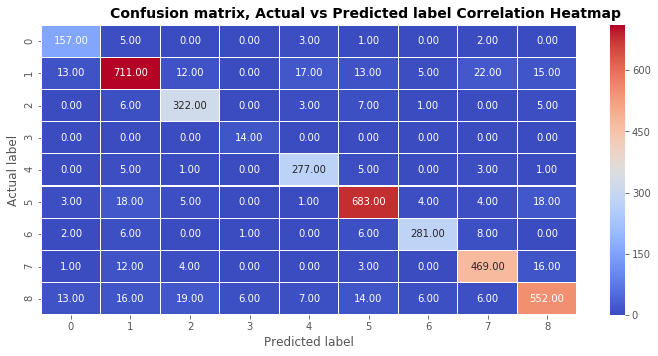

In [51]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.heatmap(pd.DataFrame(confusion_matrix(measured2,Y_data2['surface'])),
            ax = ax,
            cmap = 'coolwarm',
            annot = True,
            fmt = '.2f',
            linewidths = 0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Confusion matrix, Actual vs Predicted label Correlation Heatmap',
              fontsize=14,
              fontweight='bold')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')